In [1]:
from collections import deque
from copy import deepcopy

import gym
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
from torch.utils.data import DataLoader

SEED = 1
BATCH_SIZE = 8
LR = 0.00030
EPOCHS = 4
CLIP = 0.1
GAMMA = 0.99
LAMBDA = 0.94
ENT_COEF = 0.0
V_CLIP = True

# set device
use_cuda = torch.cuda.is_available()
print('cuda:', use_cuda)
device = torch.device('cuda' if use_cuda else 'cpu')

# random seed
np.random.seed(SEED)
torch.manual_seed(SEED)
if use_cuda:
    torch.cuda.manual_seed_all(SEED)


class ActorCriticNet(nn.Module):
    def __init__(self, obs_space, action_space):
        super().__init__()

        self.head = nn.Sequential(
            nn.Linear(obs_space, obs_space*10),
            nn.SELU()
        )
        self.pol = nn.Sequential(
            nn.Linear(obs_space*10, 512),
            nn.SELU(),
            nn.Linear(512, 512),
            nn.SELU(),
            nn.Linear(512, action_space)
        )
        self.val = nn.Sequential(
            nn.Linear(obs_space*10, 512),
            nn.SELU(),
            nn.Linear(512, 512),
            nn.SELU(),
            nn.Linear(512, 1)
        )
        self.log_softmax = nn.LogSoftmax(dim=-1)

    def forward(self, x):
        out = self.head(x)
        logit = self.pol(out).reshape(out.shape[0], -1)
        log_p = self.log_softmax(logit)
        v = self.val(out).reshape(out.shape[0], 1)

        return log_p, v


losses = []


def learn(net, old_net, optimizer, train_memory):
    global CLIP
    net.train()
    old_net.train()

    for i in range(EPOCHS):
        dataloader = DataLoader(
            train_memory,
            shuffle=True,
            batch_size=BATCH_SIZE,
            pin_memory=use_cuda
        )
        for (s, a, _s, ret, adv) in dataloader:
            s_batch = s.to(device).float()
            a_batch = a.to(device).long()
            _s_batch = _s.to(device).float()
            ret_batch = ret.to(device).float()
            adv_batch = adv.to(device).float()
            with torch.no_grad():
                log_p_batch_old, v_batch_old = old_net(s_batch)
                log_p_acting_old = log_p_batch_old[range(BATCH_SIZE), a_batch]

            log_p_batch, v_batch = net(s_batch)
            log_p_acting = log_p_batch[range(BATCH_SIZE), a_batch]
            p_ratio = (log_p_acting - log_p_acting_old).exp()
            p_ratio_clip = torch.clamp(p_ratio, 1. - CLIP, 1. + CLIP)
            p_loss = torch.min(p_ratio * adv_batch,
                               p_ratio_clip * adv_batch).mean()
            if V_CLIP:
                v_clip = v_batch_old + \
                    torch.clamp(v_batch - v_batch_old, -CLIP, CLIP)
                v_loss1 = (ret_batch - v_clip).pow(2)
                v_loss2 = (ret_batch - v_batch).pow(2)
                v_loss = torch.max(v_loss1, v_loss2).mean()
            else:
                v_loss = (ret_batch - v_batch).pow(2).mean()

            m = Categorical(log_p_batch.exp())
            entropy = m.entropy().mean()

            # loss
            loss = -(p_loss - 0.5 * v_loss + ENT_COEF * entropy)
            losses.append(loss)

            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(net.parameters(), max_norm=0.5)
            optimizer.step()
#         CLIP = max(CLIP * 0.999, 0.001)
    train_memory.clear()


def get_action_and_value(obs, old_net):
    old_net.eval()
    with torch.no_grad():
        state = torch.tensor([obs]).to(device).float()
        log_p, v = old_net(state)
        m = Categorical(log_p.exp())
        action = m.sample()

    return action.item(), v.item()


def compute_adv_with_gae(rewards, values, roll_memory):
    rew = np.array(rewards, 'float')
    val = np.array(values[:-1], 'float')
    _val = np.array(values[1:], 'float')
    delta = rew + GAMMA * _val - val
    dis_r = np.array([GAMMA**(i) * r for i, r in enumerate(rewards)], 'float')
    gae_dt = np.array([(GAMMA * LAMBDA)**(i) * dt for i,
                       dt in enumerate(delta.tolist())], 'float')
    for i, data in enumerate(roll_memory):
        data.append(sum(dis_r[i:] / GAMMA**(i)))
        data.append(sum(gae_dt[i:] / (GAMMA * LAMBDA)**(i)))
    
    rewards.clear()
    values.clear()

    return roll_memory

cuda: True


In [2]:
# make an environment
# env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
env = gym.make('MountainCar-v0')
# env = gym.make('LunarLander-v2')

env.seed(SEED)
obs_space = env.observation_space.shape[0]
action_space = env.action_space.n

# hyperparameter
n_episodes = 2000
roll_len = 256
update_frq = 1
n_eval = env.spec.trials

# global values
steps = 0
learn_steps = 0
ep_rewards = []
reward_eval = deque(maxlen=n_eval)
is_rollout = False
is_solved = False

# make memories
net_memory = deque(maxlen=2)
train_memory = []
roll_memory = []
rewards = []
values = []

# make nerual networks
net = ActorCriticNet(obs_space, action_space).to(device)
old_net = deepcopy(net)

# make a optimizer
optimizer = optim.Adam(net.parameters(), lr=LR, eps=1e-5)

# play!
for i in range(1, n_episodes + 1):
    obs = env.reset()
    done = False
    ep_reward = 0
    while not done:
#         env.render()
        action, value = get_action_and_value(obs, old_net)
        _obs, reward, done, _ = env.step(action)

        # store
        roll_memory.append([obs, action, _obs])
        rewards.append(reward)
        values.append(value)

        obs = _obs
        steps += 1
        ep_reward += reward

        if done or steps % roll_len == 0:
            if done:
                _value = 0.
            else:
                _, _value = get_action_and_value(_obs, old_net)

            values.append(_value)
            train_memory.extend(compute_adv_with_gae(
                rewards, values, roll_memory))
            roll_memory.clear()

        if steps % (roll_len * update_frq) == 0:
            learn(net, old_net, optimizer, train_memory)
            old_net.load_state_dict(net.state_dict())

    if done:
        ep_rewards.append(ep_reward)
        print('{:3} Episode in {:5} steps, reward {:.2f}'.format(
            i, steps, ep_reward))

        if len(ep_rewards) >= n_eval:
            if np.mean(list(reversed(ep_rewards))[: n_eval]) >= env.spec.reward_threshold:
                print('\n{} is sloved! {:3} Episode in {:3} steps'.format(
                    env.spec.id, i, steps))
                torch.save(net.state_dict(),
                           f'./test/saved_models/{env.spec.id}_ep{i}_clear_model_ppo_st.pt')
                break
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/jay/anaconda3/lib/python3.7/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


  1 Episode in   200 steps, reward -200.00
  2 Episode in   400 steps, reward -200.00
  3 Episode in   600 steps, reward -200.00
  4 Episode in   800 steps, reward -200.00
  5 Episode in  1000 steps, reward -200.00
  6 Episode in  1200 steps, reward -200.00
  7 Episode in  1400 steps, reward -200.00
  8 Episode in  1600 steps, reward -200.00
  9 Episode in  1800 steps, reward -200.00
 10 Episode in  2000 steps, reward -200.00
 11 Episode in  2200 steps, reward -200.00
 12 Episode in  2400 steps, reward -200.00
 13 Episode in  2600 steps, reward -200.00
 14 Episode in  2800 steps, reward -200.00
 15 Episode in  3000 steps, reward -200.00
 16 Episode in  3200 steps, reward -200.00
 17 Episode in  3400 steps, reward -200.00
 18 Episode in  3600 steps, reward -200.00
 19 Episode in  3800 steps, reward -200.00
 20 Episode in  4000 steps, reward -200.00
 21 Episode in  4200 steps, reward -200.00
 22 Episode in  4400 steps, reward -200.00
 23 Episode in  4600 steps, reward -200.00
 24 Episode

192 Episode in 38400 steps, reward -200.00
193 Episode in 38600 steps, reward -200.00
194 Episode in 38800 steps, reward -200.00
195 Episode in 39000 steps, reward -200.00
196 Episode in 39200 steps, reward -200.00
197 Episode in 39400 steps, reward -200.00
198 Episode in 39600 steps, reward -200.00
199 Episode in 39800 steps, reward -200.00
200 Episode in 40000 steps, reward -200.00
201 Episode in 40200 steps, reward -200.00
202 Episode in 40400 steps, reward -200.00
203 Episode in 40600 steps, reward -200.00
204 Episode in 40800 steps, reward -200.00
205 Episode in 41000 steps, reward -200.00
206 Episode in 41200 steps, reward -200.00
207 Episode in 41400 steps, reward -200.00
208 Episode in 41600 steps, reward -200.00
209 Episode in 41800 steps, reward -200.00
210 Episode in 42000 steps, reward -200.00
211 Episode in 42200 steps, reward -200.00
212 Episode in 42400 steps, reward -200.00
213 Episode in 42600 steps, reward -200.00
214 Episode in 42800 steps, reward -200.00
215 Episode

383 Episode in 76600 steps, reward -200.00
384 Episode in 76800 steps, reward -200.00
385 Episode in 77000 steps, reward -200.00
386 Episode in 77200 steps, reward -200.00
387 Episode in 77400 steps, reward -200.00
388 Episode in 77600 steps, reward -200.00
389 Episode in 77800 steps, reward -200.00
390 Episode in 78000 steps, reward -200.00
391 Episode in 78200 steps, reward -200.00
392 Episode in 78400 steps, reward -200.00
393 Episode in 78600 steps, reward -200.00
394 Episode in 78800 steps, reward -200.00
395 Episode in 79000 steps, reward -200.00
396 Episode in 79200 steps, reward -200.00
397 Episode in 79400 steps, reward -200.00
398 Episode in 79600 steps, reward -200.00
399 Episode in 79800 steps, reward -200.00
400 Episode in 80000 steps, reward -200.00
401 Episode in 80200 steps, reward -200.00
402 Episode in 80400 steps, reward -200.00
403 Episode in 80600 steps, reward -200.00
404 Episode in 80800 steps, reward -200.00
405 Episode in 81000 steps, reward -200.00
406 Episode

573 Episode in 114600 steps, reward -200.00
574 Episode in 114800 steps, reward -200.00
575 Episode in 115000 steps, reward -200.00
576 Episode in 115200 steps, reward -200.00
577 Episode in 115400 steps, reward -200.00
578 Episode in 115600 steps, reward -200.00
579 Episode in 115800 steps, reward -200.00
580 Episode in 116000 steps, reward -200.00
581 Episode in 116200 steps, reward -200.00
582 Episode in 116400 steps, reward -200.00
583 Episode in 116600 steps, reward -200.00
584 Episode in 116800 steps, reward -200.00
585 Episode in 117000 steps, reward -200.00
586 Episode in 117200 steps, reward -200.00
587 Episode in 117400 steps, reward -200.00
588 Episode in 117600 steps, reward -200.00
589 Episode in 117800 steps, reward -200.00
590 Episode in 118000 steps, reward -200.00
591 Episode in 118200 steps, reward -200.00
592 Episode in 118400 steps, reward -200.00
593 Episode in 118600 steps, reward -200.00
594 Episode in 118800 steps, reward -200.00
595 Episode in 119000 steps, rew

760 Episode in 152000 steps, reward -200.00
761 Episode in 152200 steps, reward -200.00
762 Episode in 152400 steps, reward -200.00
763 Episode in 152600 steps, reward -200.00
764 Episode in 152800 steps, reward -200.00
765 Episode in 153000 steps, reward -200.00
766 Episode in 153200 steps, reward -200.00
767 Episode in 153400 steps, reward -200.00
768 Episode in 153600 steps, reward -200.00
769 Episode in 153800 steps, reward -200.00
770 Episode in 154000 steps, reward -200.00
771 Episode in 154200 steps, reward -200.00
772 Episode in 154400 steps, reward -200.00
773 Episode in 154600 steps, reward -200.00
774 Episode in 154800 steps, reward -200.00
775 Episode in 155000 steps, reward -200.00
776 Episode in 155200 steps, reward -200.00
777 Episode in 155400 steps, reward -200.00
778 Episode in 155600 steps, reward -200.00
779 Episode in 155800 steps, reward -200.00
780 Episode in 156000 steps, reward -200.00
781 Episode in 156200 steps, reward -200.00
782 Episode in 156400 steps, rew

948 Episode in 189600 steps, reward -200.00
949 Episode in 189800 steps, reward -200.00
950 Episode in 190000 steps, reward -200.00
951 Episode in 190200 steps, reward -200.00
952 Episode in 190400 steps, reward -200.00
953 Episode in 190600 steps, reward -200.00
954 Episode in 190800 steps, reward -200.00
955 Episode in 191000 steps, reward -200.00
956 Episode in 191200 steps, reward -200.00
957 Episode in 191400 steps, reward -200.00
958 Episode in 191600 steps, reward -200.00
959 Episode in 191800 steps, reward -200.00
960 Episode in 192000 steps, reward -200.00
961 Episode in 192200 steps, reward -200.00
962 Episode in 192400 steps, reward -200.00
963 Episode in 192600 steps, reward -200.00
964 Episode in 192800 steps, reward -200.00
965 Episode in 193000 steps, reward -200.00
966 Episode in 193200 steps, reward -200.00
967 Episode in 193400 steps, reward -200.00
968 Episode in 193600 steps, reward -200.00
969 Episode in 193800 steps, reward -200.00
970 Episode in 194000 steps, rew

1132 Episode in 226400 steps, reward -200.00
1133 Episode in 226600 steps, reward -200.00
1134 Episode in 226800 steps, reward -200.00
1135 Episode in 227000 steps, reward -200.00
1136 Episode in 227200 steps, reward -200.00
1137 Episode in 227400 steps, reward -200.00
1138 Episode in 227600 steps, reward -200.00
1139 Episode in 227800 steps, reward -200.00
1140 Episode in 228000 steps, reward -200.00
1141 Episode in 228200 steps, reward -200.00
1142 Episode in 228400 steps, reward -200.00
1143 Episode in 228600 steps, reward -200.00
1144 Episode in 228800 steps, reward -200.00
1145 Episode in 229000 steps, reward -200.00
1146 Episode in 229200 steps, reward -200.00
1147 Episode in 229400 steps, reward -200.00
1148 Episode in 229600 steps, reward -200.00
1149 Episode in 229800 steps, reward -200.00
1150 Episode in 230000 steps, reward -200.00
1151 Episode in 230200 steps, reward -200.00
1152 Episode in 230400 steps, reward -200.00
1153 Episode in 230600 steps, reward -200.00
1154 Episo

1315 Episode in 263000 steps, reward -200.00
1316 Episode in 263200 steps, reward -200.00
1317 Episode in 263400 steps, reward -200.00
1318 Episode in 263600 steps, reward -200.00
1319 Episode in 263800 steps, reward -200.00
1320 Episode in 264000 steps, reward -200.00
1321 Episode in 264200 steps, reward -200.00
1322 Episode in 264400 steps, reward -200.00
1323 Episode in 264600 steps, reward -200.00
1324 Episode in 264800 steps, reward -200.00
1325 Episode in 265000 steps, reward -200.00
1326 Episode in 265200 steps, reward -200.00
1327 Episode in 265400 steps, reward -200.00
1328 Episode in 265600 steps, reward -200.00
1329 Episode in 265800 steps, reward -200.00
1330 Episode in 266000 steps, reward -200.00
1331 Episode in 266200 steps, reward -200.00
1332 Episode in 266400 steps, reward -200.00
1333 Episode in 266600 steps, reward -200.00
1334 Episode in 266800 steps, reward -200.00
1335 Episode in 267000 steps, reward -200.00
1336 Episode in 267200 steps, reward -200.00
1337 Episo

1498 Episode in 299600 steps, reward -200.00
1499 Episode in 299800 steps, reward -200.00
1500 Episode in 300000 steps, reward -200.00
1501 Episode in 300200 steps, reward -200.00
1502 Episode in 300400 steps, reward -200.00
1503 Episode in 300600 steps, reward -200.00
1504 Episode in 300800 steps, reward -200.00
1505 Episode in 301000 steps, reward -200.00
1506 Episode in 301200 steps, reward -200.00
1507 Episode in 301400 steps, reward -200.00
1508 Episode in 301600 steps, reward -200.00
1509 Episode in 301800 steps, reward -200.00
1510 Episode in 302000 steps, reward -200.00
1511 Episode in 302200 steps, reward -200.00
1512 Episode in 302400 steps, reward -200.00
1513 Episode in 302600 steps, reward -200.00
1514 Episode in 302800 steps, reward -200.00
1515 Episode in 303000 steps, reward -200.00
1516 Episode in 303200 steps, reward -200.00
1517 Episode in 303400 steps, reward -200.00
1518 Episode in 303600 steps, reward -200.00
1519 Episode in 303800 steps, reward -200.00
1520 Episo

1681 Episode in 336200 steps, reward -200.00
1682 Episode in 336400 steps, reward -200.00
1683 Episode in 336600 steps, reward -200.00
1684 Episode in 336800 steps, reward -200.00
1685 Episode in 337000 steps, reward -200.00
1686 Episode in 337200 steps, reward -200.00
1687 Episode in 337400 steps, reward -200.00
1688 Episode in 337600 steps, reward -200.00
1689 Episode in 337800 steps, reward -200.00
1690 Episode in 338000 steps, reward -200.00
1691 Episode in 338200 steps, reward -200.00
1692 Episode in 338400 steps, reward -200.00
1693 Episode in 338600 steps, reward -200.00
1694 Episode in 338800 steps, reward -200.00
1695 Episode in 339000 steps, reward -200.00
1696 Episode in 339200 steps, reward -200.00
1697 Episode in 339400 steps, reward -200.00
1698 Episode in 339600 steps, reward -200.00
1699 Episode in 339800 steps, reward -200.00
1700 Episode in 340000 steps, reward -200.00
1701 Episode in 340200 steps, reward -200.00
1702 Episode in 340400 steps, reward -200.00
1703 Episo

1864 Episode in 372800 steps, reward -200.00
1865 Episode in 373000 steps, reward -200.00
1866 Episode in 373200 steps, reward -200.00
1867 Episode in 373400 steps, reward -200.00
1868 Episode in 373600 steps, reward -200.00
1869 Episode in 373800 steps, reward -200.00
1870 Episode in 374000 steps, reward -200.00
1871 Episode in 374200 steps, reward -200.00
1872 Episode in 374400 steps, reward -200.00
1873 Episode in 374600 steps, reward -200.00
1874 Episode in 374800 steps, reward -200.00
1875 Episode in 375000 steps, reward -200.00
1876 Episode in 375200 steps, reward -200.00
1877 Episode in 375400 steps, reward -200.00
1878 Episode in 375600 steps, reward -200.00
1879 Episode in 375800 steps, reward -200.00
1880 Episode in 376000 steps, reward -200.00
1881 Episode in 376200 steps, reward -200.00
1882 Episode in 376400 steps, reward -200.00
1883 Episode in 376600 steps, reward -200.00
1884 Episode in 376800 steps, reward -200.00
1885 Episode in 377000 steps, reward -200.00
1886 Episo

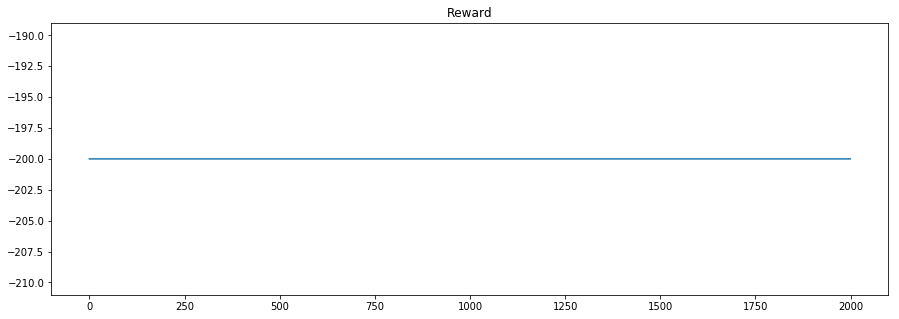

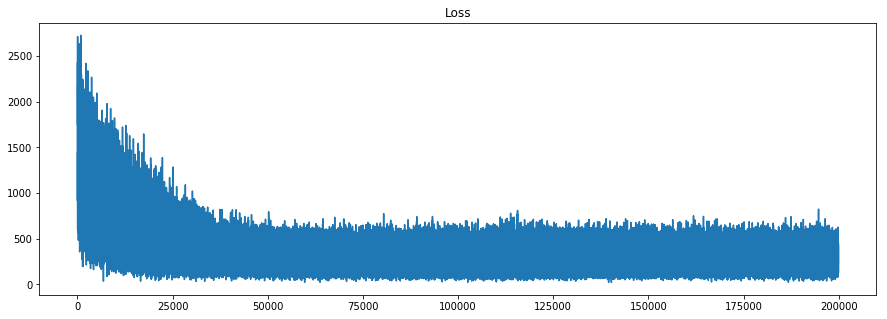

In [3]:
plt.figure(figsize=(15, 5))
plt.title('Reward')
plt.plot(ep_rewards)
plt.figure(figsize=(15, 5))
plt.title('Loss')
plt.plot(losses)
plt.show()

In [4]:
[
    ('CartPole-v0', 127, 32, 128),
    ('CartPole-v1', 147, 8, 256),
    ('MountainCar-v0', None),
    ('LunarLander-v2', None)
]

[('CartPole-v0', 127, 32, 128),
 ('CartPole-v1', 147, 32, 256),
 ('MountainCar-v0', None),
 ('LunarLander-v2', None)]